# import package

In [1]:
import thunder as td

import pandas as pd

import matplotlib.pyplot as plt

import os

from showit import tile

from showit import image

from regional import one

import nibabel as nib

import seaborn as sns

import numpy as np

import sklearn

from skimage.transform import resize

import station

import nilearn

from nilearn import datasets

import skimage

from numpy import rollaxis


%matplotlib inline
sns.set_style('darkgrid')
sns.set_context('notebook')

In [2]:
from sklearn.decomposition import PCA
from sklearn.decomposition import IncrementalPCA
pca_model = PCA(n_components=20, copy=True, whiten=False, svd_solver='auto', 
            tol=0.0, iterated_power='auto', random_state=None)
IPCA_model = IncrementalPCA(batch_size=30)

# load data

In [3]:
NC_file_path = "/Volumes/耳鼻喉陈军/1dataset/gz_NC"

AD_file_path = "/Volumes/耳鼻喉陈军/1dataset/gz_AD"

In [4]:
AD_name = os.listdir(AD_file_path)

AD_name.remove('4D_original')

NC_name = os.listdir(NC_file_path)
NC_name.remove('4D_original')

total = AD_name + NC_name

# read data + pca + connecting all subject

In [7]:
def first_reduce(subjects):
    reduce_dimension = list()
    for i in range(len(subjects)):
        if i < len(AD_name):
            file = nib.load(AD_file_path + "/" + subjects[i])
        else:
            file = nib.load(NC_file_path + "/" + subjects[i])
            
        data = file.get_data()

        data = data.transpose(3,0,1,2)

        figure = td.images.fromarray(data).gaussian_filter(sigma=6, order=0)

        input_array = figure.toseries().flatten().normalize(method='mean', window=None, offset=0.1).toarray()


        after_pca = pca_model.fit_transform(input_array)
        print(after_pca.shape)
        reduce_dimension.append(pca_model.components_)

        if i == 0:
            total_input = after_pca
        else:
            total_input = np.hstack((total_input,after_pca))
    return total_input,reduce_dimension


In [ ]:
total_input,reduce_dimension = first_reduce(total)

In [9]:
total_input.shape

(196608, 2320)

In [11]:
reduce_dimension[0].shape

(20, 140)

In [256]:
len(reduce_dimension)

116

# group PCA

In [296]:
group_PCA = IPCA_model.fit_transform(total_input)

/Users/tianyichen/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/incremental_pca.py:294: RuntimeWarning: Mean of empty slice.
  explained_variance[self.n_components_:].mean()
/Users/tianyichen/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [297]:
group_PCA.shape

(196608, 30)

In [298]:
reduce_matrix = IPCA_model.components_
reduce_matrix.shape

(30, 2320)

# try another method (poor performance)

In [237]:
model = PCA(n_components=90, copy=True, whiten=False, svd_solver='auto', 
            tol=0.0, iterated_power='auto', random_state=None)
try_pratial = []

for i in range(4):
    if i ==0:
        index = 0
    else:
        index = i+580
    partial = total_input[:,index:index+580]
    array = model.fit_transform(partial)
    reduce_try = model.components_
    
    try_pratial.append(reduce_try)
    if i ==0:
        result_partial = array
    else:
        result_partial = np.hstack((result_partial,array))

In [251]:
result_partial.shape

(196608, 360)

In [255]:
len(try_pratial)

4

In [252]:
from sklearn.decomposition import FastICA
transformer = FastICA(n_components=30, algorithm='parallel', whiten=True, 
                      fun='logcosh', fun_args=None, max_iter=2000, tol=0.0001, w_init=None, random_state=None)

test_fast = transformer.fit(result_partial)

mixing_matrix = test_fast.mixing_
mixing_matrix.shape

unmixing_matrix = test_fast.components_
unmixing_matrix.shape

output = test_fast.transform(result_partial)

In [254]:
unmixing_matrix.shape

(90, 360)

In [266]:
try_pratial[3][:,0:20].shape

(90, 20)

In [280]:
feature_vector=[]
time_pca = PCA(n_components=30, copy=True, whiten=False, svd_solver='auto', 
            tol=0.0, iterated_power='auto', random_state=None)
for i in range(4):
    if i == 0:
        index1 = i
    else:
        index1 = index1+90
    partial_time = unmixing_matrix[:,index1:index1+90]
    
    for j in range(29):
 
        reduce2 = try_pratial[i][:,(j*20):(20*j+20)]
       
        s = np.dot(partial_time,reduce2)
        ss = np.dot(s,reduce_dimension[i*j+j])
        
        inputs = time_pca.fit_transform(ss.T)
        inputs = inputs.T
        spartial_series = td.series.fromarray(inputs)
        cross_list = list()
        for k in range(30):
            for m in range(k+1,30):

                cross = spartial_series[k].crosscorr(spartial_series[m]).toarray().tolist()

                cross_list.append(cross)

        feature_vector.append(cross_list)

In [281]:
len(feature_vector)

116

# groupICA 

In [299]:
from sklearn.decomposition import FastICA
transformer = FastICA(n_components=30, algorithm='parallel', whiten=True, 
                      fun='logcosh', fun_args=None, max_iter=2000, tol=0.0001, w_init=None, random_state=None)

test_fast = transformer.fit(group_PCA)

mixing_matrix = test_fast.mixing_
mixing_matrix.shape

unmixing_matrix = test_fast.components_
unmixing_matrix.shape

output = test_fast.transform(group_PCA)

In [300]:
output.shape

(196608, 30)

# data reconstruction

In [301]:
reconst_series = td.series.fromarray(reduce_matrix)
reconst_series

Series
mode: local
dtype: float64
shape: (30, 2320)

In [370]:
time_course = list()
feature_vector = list()
def reconstruction(reduce1,reduce2):
    for i in range(len(total)):
        if i ==0:
            limit = i
        else:
            limit = limit+20
        s = np.dot(unmixing_matrix,reduce2.between(limit,limit+20).toarray())
        ss = np.dot(s,reduce1[i])
        time_course.append(ss)
        spartial_series = td.series.fromarray(ss)
        cross_list = list()
        for i in range(30):
            for j in range(i+1,30):

                cross = spartial_series[i].crosscorr(spartial_series[j]).toarray().tolist()

                cross_list.append(cross)

        feature_vector.append(cross_list)
    return feature_vector,time_course

In [371]:
feature_vector,time_course = reconstruction(reduce_dimension,reconst_series)

# labelling

In [495]:
label = list()
for i in range(len(total)):
    if i<58:
        label.append(1)
    else:
        label.append(-1)

In [496]:
#把统一处理的数据分为测试集和训练集

from sklearn import svm
from sklearn.metrics import accuracy_score

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
from sklearn import metrics
from random import sample

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import LeaveOneOut


#data_train,data_test,label_train,label_test = train_test_split(feature_vector, label, train_size=0.85, test_size = 0.15)

# Three classification method

# SVM

In [563]:
whole_pred = list()
whole_test = list()
svm_accuracy_list = list()
for i in range(20):
    data_train,data_test,label_train,label_test = train_test_split(feature_vector, label, train_size=0.75, test_size = 0.25,random_state = i*10)
    clf = svm.SVC(C=1.0, kernel='linear', decision_function_shape='ovr')
    clf.fit(np.array(data_train), label_train)
    y_pred = clf.predict(np.array(data_test))
    #print(metrics.accuracy_score(label_test,y_pred)) 
    svm_accuracy_list.append(metrics.accuracy_score(label_test,y_pred))
    whole_pred.extend(y_pred)
    whole_test.extend(label_test)
#loo = LeaveOneOut()

#y_pred = np.zeros(np.array(label).shape)
#for train, test in loo.split(feature_vector):
    
    #clf.fit(np.array(feature_vector)[train], np.array(label)[train])
    #y_pred[test] = clf.predict(np.array(feature_vector)[test])

#y_pred = clf.predict(data_test)

#print("Accuracy:",metrics.accuracy_score(label,y_pred))    

In [564]:
metrics.accuracy_score(np.array(whole_pred),np.array(whole_test))

0.7241379310344828

In [535]:
from sklearn.metrics import precision_score  
from sklearn.metrics import recall_score 
print("the classification report:")  

print(metrics.classification_report(whole_test,whole_pred,digits = 4))
print("the confusion matrix:")  

print(metrics.confusion_matrix(whole_test,whole_pred))

print(precision_score(whole_test, whole_pred))
print(recall_score(whole_test, whole_pred))

the classification report:
              precision    recall  f1-score   support

          -1     0.7313    0.7264    0.7288       296
           1     0.7168    0.7218    0.7193       284

   micro avg     0.7241    0.7241    0.7241       580
   macro avg     0.7240    0.7241    0.7241       580
weighted avg     0.7242    0.7241    0.7242       580

the confusion matrix:
[[215  81]
 [ 79 205]]
0.7167832167832168
0.721830985915493


In [525]:
tn, fp, fn, tp = metrics.confusion_matrix(whole_test,whole_pred).ravel()

In [531]:
print(tn, fp, fn, tp)

215 81 79 205


In [565]:
final_accuracy1 = np.mean(svm_accuracy_list)

In [566]:
final_accuracy1

0.7241379310344828

In [567]:
final_accuracy2 = np.std(svm_accuracy_list)

In [568]:
final_accuracy2

0.04997026464203254

In [569]:
svm_accuracy_list

[0.7931034482758621,
 0.6551724137931034,
 0.7931034482758621,
 0.7241379310344828,
 0.6896551724137931,
 0.8275862068965517,
 0.6206896551724138,
 0.7241379310344828,
 0.6896551724137931,
 0.7241379310344828,
 0.7241379310344828,
 0.7241379310344828,
 0.6896551724137931,
 0.7241379310344828,
 0.6896551724137931,
 0.6896551724137931,
 0.6896551724137931,
 0.7586206896551724,
 0.7586206896551724,
 0.7931034482758621]

# logistic regression

In [570]:

log_result = list()
log_whole_test = list()
log_whole_pred = list()
from sklearn.linear_model import LogisticRegression

logreg=LogisticRegression(penalty='l2', dual=False, 
    tol=0.00001, C=1.0, fit_intercept=True, 
    intercept_scaling=1, class_weight=None, 
    random_state=9, solver='warn', max_iter=100,
    multi_class='warn', verbose=0, 
    warm_start=False, n_jobs=None)

for i in range(20):
    data_train,data_test,label_train,label_test = train_test_split(feature_vector, label, train_size=0.75, test_size = 0.25,random_state = i*10)
    
    logreg.fit(np.array(data_train), label_train)
    log_prediction = logreg.predict(np.array(data_test))
    #print(metrics.accuracy_score(label_test,log_prediction)) 
    log_result.append(metrics.accuracy_score(label_test,log_prediction))
    log_whole_test.extend(label_test)
    log_whole_pred.extend(log_prediction)

In [571]:
print("the classification report:")  

print(metrics.classification_report(log_whole_test,log_whole_pred,digits = 4))
print("the confusion matrix:")  

print(metrics.confusion_matrix(log_whole_test,log_whole_pred))

the classification report:
              precision    recall  f1-score   support

          -1     0.7348    0.6926    0.7130       296
           1     0.6977    0.7394    0.7179       284

   micro avg     0.7155    0.7155    0.7155       580
   macro avg     0.7162    0.7160    0.7155       580
weighted avg     0.7166    0.7155    0.7154       580

the confusion matrix:
[[205  91]
 [ 74 210]]


In [572]:
tn, fp, fn, tp = metrics.confusion_matrix(log_whole_test,log_whole_pred).ravel()
print(tn, fp, fn, tp)

205 91 74 210


In [573]:
np.mean(log_result)

0.7155172413793103

In [574]:
np.std(log_result)

0.0565296424508793

In [575]:
log_result

[0.7931034482758621,
 0.6206896551724138,
 0.7586206896551724,
 0.6551724137931034,
 0.6896551724137931,
 0.8275862068965517,
 0.6206896551724138,
 0.7241379310344828,
 0.6896551724137931,
 0.7241379310344828,
 0.7241379310344828,
 0.6896551724137931,
 0.6896551724137931,
 0.6896551724137931,
 0.6896551724137931,
 0.6896551724137931,
 0.6896551724137931,
 0.7586206896551724,
 0.7586206896551724,
 0.8275862068965517]

# Naive Bayes

In [577]:
gnb_test = list()
gnb_pred = list()
gnb_result = list()
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()
for i in range(20):
    data_train,data_test,label_train,label_test = train_test_split(feature_vector, label, train_size=0.75, test_size = 0.25,random_state = i*10)
    bayes_pred = gnb.fit(np.array(data_train), label_train).predict(data_test)
    gnb_test.extend(label_test)
    gnb_pred.extend(bayes_pred)
    gnb_result.append(metrics.accuracy_score(label_test,bayes_pred))
    
    
    

In [578]:
print("the classification report:")  

print(metrics.classification_report(gnb_test,gnb_pred,digits = 4))
print("the confusion matrix:")  

print(metrics.confusion_matrix(gnb_test,gnb_pred))

the classification report:
              precision    recall  f1-score   support

          -1     0.6958    0.6182    0.6547       296
           1     0.6435    0.7183    0.6789       284

   micro avg     0.6672    0.6672    0.6672       580
   macro avg     0.6697    0.6683    0.6668       580
weighted avg     0.6702    0.6672    0.6666       580

the confusion matrix:
[[183 113]
 [ 80 204]]


In [579]:
tn, fp, fn, tp = metrics.confusion_matrix(gnb_test,gnb_pred).ravel()
print(tn, fp, fn, tp)

183 113 80 204


In [580]:
gnb_result

[0.6551724137931034,
 0.5172413793103449,
 0.6896551724137931,
 0.6896551724137931,
 0.6206896551724138,
 0.7241379310344828,
 0.5517241379310345,
 0.7931034482758621,
 0.7931034482758621,
 0.6896551724137931,
 0.6206896551724138,
 0.7241379310344828,
 0.7241379310344828,
 0.6206896551724138,
 0.6551724137931034,
 0.5517241379310345,
 0.6551724137931034,
 0.7241379310344828,
 0.6551724137931034,
 0.6896551724137931]

In [581]:
np.mean(gnb_result)

0.6672413793103448

In [582]:
np.std(gnb_result)

0.07173325538867147

# 画ROC曲线

# The ROC curve of SVM

/Users/tianyichen/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


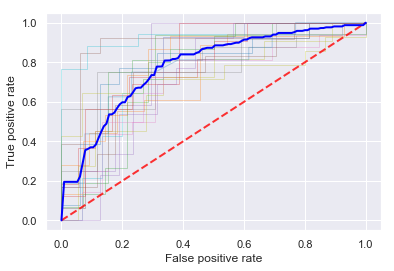

In [562]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import StratifiedKFold
from scipy import interp
#fpr, tpr, thresholds= sklearn.metrics.roc_curve(whole_test,whole_pred,pos_label=1,sample_weight=None, drop_intermediate=True)

fprs = []
tprs = []
AUCs = []
accuracy_list = list()
mean_fpr = np.linspace(0, 1, len(total))

for i in range(20):
    data_train,data_test,label_train,label_test = train_test_split(feature_vector, label, train_size=0.75, test_size = 0.25,random_state = i*10)
    clf = svm.SVC(C=1.0, kernel='linear', decision_function_shape='ovr',probability = True)
    clf.fit(np.array(data_train), label_train)
    y_prob = clf.predict_proba(np.array(data_test))
    fpr, tpr, thresholds = roc_curve(label_test, y_prob[:, 1])
    tprs.append(interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    roc_auc = auc(fpr,tpr)
    AUCs.append(roc_auc)
    plt.plot(fpr, tpr, lw=1, alpha=0.3, label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))
    
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Chance', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
#plt.plot(mean_fpr, mean_tpr, color='b',
         #label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)'% (mean_auc, std_auc),
         #lw=2, alpha=.8)
plt.plot(mean_fpr, mean_tpr, color='b',
         label='Mean ROC ',lw=2)
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.show()

In [552]:
thresholds

array([1.87414992, 0.87414992, 0.46260889, 0.45882262, 0.32841922,
       0.29914157, 0.29560444, 0.10151658, 0.06172676])

In [322]:
mean_auc

0.7782709078006393

# The ROC of logistic regression

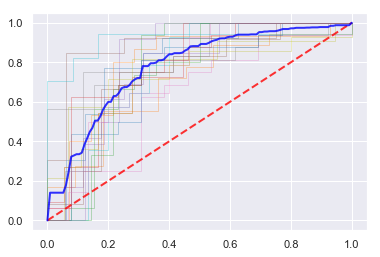

In [547]:

# import warnings filter
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)
for i in range(20):
    data_train,data_test,label_train,label_test = train_test_split(feature_vector, label, train_size=0.75, test_size = 0.25,random_state = i*10)
    
    logreg.fit(np.array(data_train), label_train)
    log_prediction = logreg.decision_function(np.array(data_test))
    #print(metrics.accuracy_score(label_test,log_prediction)) 
    fpr, tpr, thresholds = roc_curve(label_test, log_prediction)
    tprs.append(interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    roc_auc = auc(fpr,tpr)
    AUCs.append(roc_auc)
    plt.plot(fpr, tpr, lw=1, alpha=0.3, label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))
    
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Chance', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
plt.plot(mean_fpr, mean_tpr, color='b',
         label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)'% (mean_auc, std_auc),
         lw=2, alpha=.8)

In [541]:
mean_auc

0.7760217282539852

# data vilization for the preprocess

In [351]:
file = nib.load(AD_file_path + "/" + total[6])
data = file.get_data()

data = data.transpose(3,0,1,2)

figure = td.images.fromarray(data)

In [352]:
figure

Images
mode: local
dtype: float64
shape: (140, 64, 64, 48)

In [356]:
figure[0].toarray().shape

(64, 64, 48)

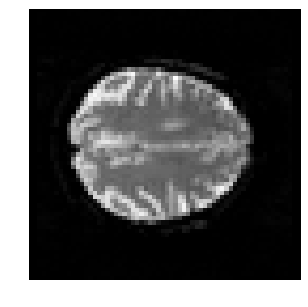

In [363]:
image(figure[50,:,:,32].toarray(), size = 5)

In [368]:
smooth = figure.gaussian_filter(sigma=2, order=0)

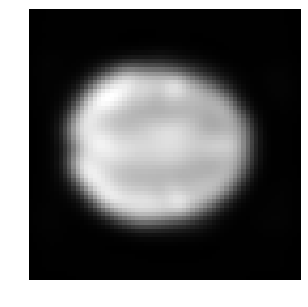

In [369]:
image(smooth[50,:,:,32].toarray(), size = 5)

In [374]:
path = "/Users/tianyichen/sheffield_studying_material/dissertation project/dataset folder/FMRI/ADNI/AD4/rp_ADNI_031_S_4024_MR_Resting_State_fMRI_br_raw_20110425135346199_2756_S105083_I228872.txt"

In [408]:
shiftx = []
shifty = []
shiftz = []
rotatex = []
rotatey = []
rotatez = []
import pandas as pd
f = open(path) 
for line in f.readlines(): 
    tx,ty,tz,rx,ry,rz = line.split()
    shiftx.append(np.float(tx))
    shifty.append(np.float(ty))
    shiftz.append(np.float(tz))
    rotatex.append(np.float(rx))
    rotatey.append(np.float(ry))
    rotatez.append(np.float(rz))

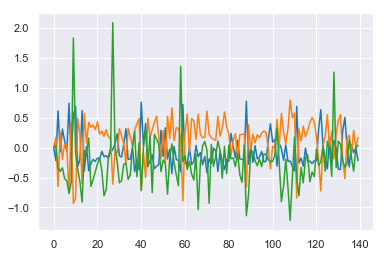

In [410]:
plt.plot(np.arange(140),np.transpose(shiftx))
plt.plot(np.arange(140),np.transpose(shifty))
plt.plot(np.arange(140),np.transpose(shiftz))

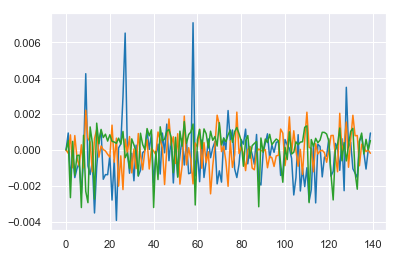

In [583]:
plt.plot(np.arange(140),np.transpose(rotatex))
plt.plot(np.arange(140),np.transpose(rotatey))
plt.plot(np.arange(140),np.transpose(rotatez))

# visualization of extracted feature

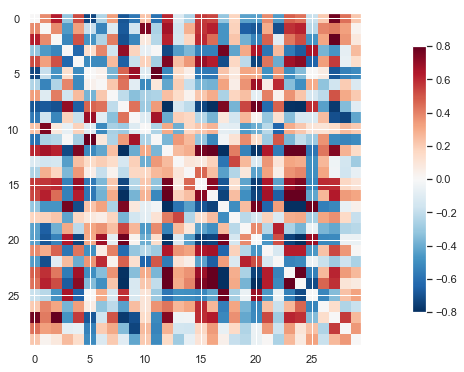

In [372]:
#the correlation matrix of one AD subject
%matplotlib inline
from nilearn.connectome import ConnectivityMeasure
correlation_measure = ConnectivityMeasure(kind='correlation')
correlation_matrix = correlation_measure.fit_transform([time_course[0].T])[0]

# Display the correlation matrix
import numpy as np
from nilearn import plotting
# Mask out the major diagonal
np.fill_diagonal(correlation_matrix, 0)
plotting.plot_matrix(correlation_matrix, labels=None, colorbar=True,
                     vmax=0.8, vmin=-0.8)

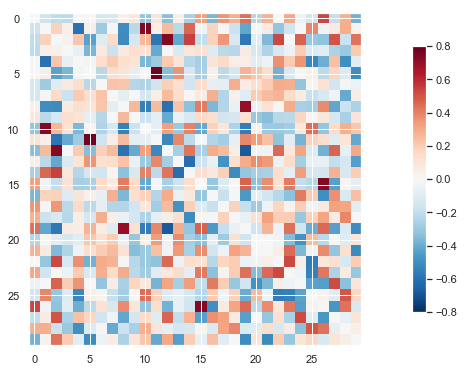

In [373]:
#the correlation matrix of one healthy subject
from nilearn.connectome import ConnectivityMeasure
correlation_measure = ConnectivityMeasure(kind='correlation')
correlation_matrix = correlation_measure.fit_transform([time_course[60].T])[0]

# Display the correlation matrix
import numpy as np
from nilearn import plotting
# Mask out the major diagonal
np.fill_diagonal(correlation_matrix, 0)
plotting.plot_matrix(correlation_matrix, labels=None, colorbar=True,
                     vmax=0.8, vmin=-0.8)